Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/7998b8a481fccd467463deb1fc46d19622079b0e/LICENSE.md)


## Building a Cortex Certifai scan programatically

In this notebook we'll build up a scan definition from first principles, against a local model trained within the notebook. We will then run that scan and save its results. 

- Load the dataset and model from disk
- Create scan definition using Certifai Builder Api
- Refer to the [Cortex Certifai documentation](https://cognitivescale.github.io/cortex-certifai/docs/about) for detailed information about Cortex Certifai.
- Refer to [Cortex Certifai Examples Github](https://github.com/CognitiveScale/cortex-certifai-examples) for more self start tutorials

*Please Note*: this notebook assumes: 
- trained model and dataset is available within the environment
- Cortex Certifai toolkit and model dependencies are installed


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue, CertifaiModelMetric,
                                      CertifaiFeatureDataType,CertifaiFeatureSchema, CertifaiDataSchema,CertifaiFeatureRestriction)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.common.utils.encoding import CatEncoder
import joblib

In [2]:
# check required packages and their version
import sklearn as scikit
print(f'sklearn version is {scikit.__version__}')
print(f'numpy version is {np.__version__} ')
!certifai --version

sklearn version is 1.0.2
numpy version is 1.21.6 
Certifai version: 1.3.16
Scanner build: 1.3.16-31-g647f507f


In [3]:
seed = 42
np.random.seed(seed)


### Load pre-trained model from disk along with encoder (if present)

- replace model_path variable below to point to stored model binary on disk


In [4]:
# load model 
model_path = 'models/german_credit_multiclass.joblib'
print(f'loading {model_path}')
try:
    model = joblib.load(model_path)
except FileNotFoundError as e:
    print(f'model `{model_path}` not found. Looks like model has not been trained or file location is wrong')
    raise Exception(str(e))
print(model)

loading models/german_credit_multiclass.joblib
Pipeline(steps=[('full_pipeline',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('model',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': (0.5, 1.0, 2.0),
                                          'max_iter': [1000],
                                          'solver': ['lbfgs']}))])


In [5]:
base_path = '../..'
all_data_file = f"{base_path}/datasets/german_credit_eval_multiclass_encoded.csv"

df = pd.read_csv(all_data_file)

one_hot_encoded_cat_cols = [
         'checkingstatus',
         'others',
         'age',
         'job',
         'employ',
         'property',
         'foreign',
         'history',
         'savings',
         'purpose',
         'housing'       
        ]

target_encoded_cat_cols = ['otherplans', 'status', 'telephone']
value_encoded_cat_cols =  []
label_column = 'outcome'


In [6]:
# create a mini certifai explanation dataset
expln_mini_data_file = f"{base_path}/datasets/german_credit_eval_multiclass_encoded_expln.csv"
df[:100].to_csv(expln_mini_data_file, index=False)

###  target_encoded string categorical to floating point encoding

### Load Dataset and create one-hot feature-value mappings dict

- our dataset has one-hot feature values encoded as dataset columns along with target_encoded categoricals
- these one-hot encoded features present as column have column names delimited using `_` e.g. `age_<= 25 years`  `age_> 25 years` etc.
- we create one hot value mappings for each  one-hot encoded feature below
(e.g. `feature`: {`column_name_correponding_to_feature`: `features_value_in_column_for_given_feature`} )
    ```
    'age': {'age_<= 25 years': '<= 25 years', 
    'age_> 25 years': '> 25 years'}
   ```
- `one_hot_value_mappings` created above will be used later used to create `CertifaiDatasetSchema` 
> **Please Note**: this is only needed in-case dataset already has one-hot encoded feature as columns. Also if you already have the persisted mappings with same schema you can use that as well

In [7]:
from collections import defaultdict
mappings = defaultdict(list)
for col in df.columns.to_list():
    col_list = []
    feature_name,feature_value = col.split('_')[0], col.split('_')[1:]
    if feature_name in one_hot_encoded_cat_cols:
        if feature_value:
            mappings[feature_name].append('_'.join(feature_value))

# create a mapping from {feature -> {1-hot_column_name_in_csv: feature_value }} using the feature `mapping` list

"""
workclass:
     workclass_Local-gov -> Local-gov
     workclass_Self-emp-inc -> Self-emp-inc
"""
one_hot_value_mappings = {}
for k,v in mappings.items():
    one_hot_value_mappings[k] = { f'{k}_{cols}':cols  for cols in v} 

### Construct target encoder mappings 
- to generate target_mappings using `category_encoders.target_encoder.TargetEncoder` (from category-encoders package) `te` object we can use the below snippet
```
target_mappings = {}
for feature in target_encode_cat_cols:
    feature_mappings = {}
    for ordinal_mapping in te.ordinal_encoder.category_mapping:
        if ordinal_mapping['col'] == feature:
            mapping = ordinal_mapping['mapping']
            for idx, ordinal in enumerate(mapping):
                label = mapping.index[idx]
                if not (isinstance(label, float) and np.isnan(label)):
                    feature_mappings[label] = te.mapping[feature][ordinal]
            break
    target_mappings[feature] = feature_mappings
```    

In [8]:
# above cell demonstrates how to create the mappings
# we use the persisted value mappings created using same code from above
# we also get the target_encoded mappings
import json
with open('../dataset_generation/cat_mappings.json', 'r') as fl:
    mappings = json.load(fl)   
print(mappings.keys())
one_hot_value_mappings = mappings.get('one_hot_encoded_mappings')
target_mappings = mappings.get('target_encoded_mappings')
print(f'---------\ntarget encoded value mappings ->\n{target_mappings}')


dict_keys(['one_hot_encoded_mappings', 'target_encoded_mappings'])
---------
target encoded value mappings ->
{'status': {'male : single': 1.4762773722627738, 'female : divorced/separated/married': 1.59999999999998, 'male : married/widowed': 1.5108778688426723, 'male : divorced/separated': 1.5581978168192525}, 'telephone': {'phone - none': 1.5906040268456376, 'phone - yes, registered under the customers name': 1.4207920792079207}, 'otherplans': {'none': 1.515970515970516, 'stores': 1.5512272565961795, 'bank': 1.5467624217811897}}


## Certifai Evaluation Setup

### create Certifai model proxy

- [CertifaiPredictorWrapper](https://cognitivescale.github.io/cortex-certifai/docs/reference/api/) API is used to wrap model objects with encoder/decoder callables
- if model has encoding, decoding capabilities built into it, `encoder`/`decoder` kwargs need not be provided

In [9]:
model_proxy = CertifaiPredictorWrapper(model)

### test wrapped model_proxy predicts

In [10]:
# # test to assert wrapped certifai model predicts == raw model predicts
assert (model_proxy.model.predict(df.drop(label_column,axis=1)[:10].values) == 
        model.predict(df.drop(label_column, axis=1)[:10].values)).all


### define  Certifai task type

- CertifaiTaskOutcomes : Cortex Certifai supports classification as well as regression models. Here we have an example of multiclass classificaton (e.g. Determine whether a loan should be granted)
- CertifaiOutcomeValue : define the outcomes possible from the model predictions. here we have a multiclass classification model that predicts whether loan will be 
- `granted`,
- `denied` or sent for
- `further inspection`


Note: Please refer to Certifai API [documentation](https://cognitivescale.github.io/cortex-certifai/docs/reference/api/) for more details.

In [11]:
# Create Certifai evaluation task and add that to scan object
# First define the possible prediction outcomes

task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied', favorable=False),
        CertifaiOutcomeValue(3, name='further inspection', favorable=False)
    ],
    favorable_outcome_group_name = 'Loan Granted',
    unfavorable_outcome_group_name = 'Loan Denied or subject to futher inspection'
),
                     
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('german_credit_multiclass',
                                  prediction_task=task)

### add the model to be evaluated from above

In [12]:
first_model = CertifaiModel('german_credit_multiclass', local_predictor=model_proxy)
scan.add_model(first_model)

### create `CertifaiFeatureSchema` using categorical mappings dict from above

- for one-hot encoded features we use `one_hot_value_mappings` from above to let Certifai know the different features values along with data types for that particular feature
- for target encoded and value encoded features we let Certifai know their unique sets of values
- define [CertifaiFeatureDataType](https://cognitivescale.github.io/cortex-certifai/docs/reference/api/) for categorical features
- define [CertifaiFeatureSchema](https://cognitivescale.github.io/cortex-certifai/docs/reference/api/) for the datatype created above
- add the schema to [CertifaiDataSchema](https://cognitivescale.github.io/cortex-certifai/docs/reference/api/)

In [13]:
cat_features = []
for feature in one_hot_encoded_cat_cols + target_encoded_cat_cols + value_encoded_cat_cols:
    if feature in one_hot_value_mappings:
        data_type = CertifaiFeatureDataType.categorical(value_columns=one_hot_value_mappings[feature].items())
        feature_schema = CertifaiFeatureSchema(name=feature,
                                               data_type=data_type)
        cat_features.append(feature_schema)

    elif feature in target_encoded_cat_cols:
        data_type = CertifaiFeatureDataType.categorical(values=list(target_mappings[feature].keys()),
                                                        target_encodings=list(target_mappings[feature].values()))
        feature_schema = CertifaiFeatureSchema(name=feature,
                                               data_type=data_type)
        cat_features.append(feature_schema)

    elif feature in df.columns:
        data_type = CertifaiFeatureDataType.categorical(values=sorted(df[feature].unique().tolist()))
        feature_schema = CertifaiFeatureSchema(name=feature,
                                               data_type=data_type)
        cat_features.append(feature_schema)
        
# certifai dataset schema combining numerical categorical, 1-hot and target encoded features
schema = CertifaiDataSchema(features=cat_features)
scan.dataset_schema = schema   

### Add Certifai Evaluation 

In [14]:
# certifai evaluation setup

# Add the explanation dataset. Here we run explanations for first 100 rows from the dataset

expn_dataset = CertifaiDataset('explanation',
                               CertifaiDatasetSource.csv(expln_mini_data_file))
scan.add_dataset(expn_dataset)
scan.explanation_dataset_id = 'explanation'


# add the evaluation for performance, explainability, robustness, fairness
scan.add_evaluation_type('explanation')
scan.add_evaluation_type('explainability')
scan.add_evaluation_type('robustness')
scan.add_evaluation_type('fairness')
scan.add_metric(CertifaiModelMetric('accuracy', certifai_metric='accuracy'))
scan.atx_performance_metric = 'accuracy'
scan.add_evaluation_type('performance')


# add fairness features

# set fairness features
fairness_fields = ['status', 'age']

for feature in fairness_fields:
    scan.add_fairness_grouping_feature(CertifaiGroupingFeature(feature))

# add the evaluation dataset from dataframe loaded at the start of the notebook        
eval_dataset = CertifaiDataset('evaluation',
                           CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)
scan.evaluation_dataset_id = 'evaluation'
scan.test_dataset_id = 'evaluation'

### specify target column if present in dataset

In [15]:
# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = label_column

In [16]:
# generate and save the scan definition
generated_scan_def = scan.extract_yaml()
local_scan_definition_file = 'target_encoded_gcredit_multiclass_scan_def.yaml'

with open(local_scan_definition_file, 'w') as f:
    scan.save(f)

2023-01-19 20:04:07,186 root   WARNING  The model 'german_credit_multiclass' was locally defined and cannot be represented within a scan definition because it doesn't have a 'predict_endpoint'. A default value of '<UNKNOWN_ENDPOINT>' will be used in the exported YAML for the models 'predict_endpoint'. Before running a scan with the exported YAML, you should deploy the model and update the 'german_credit_multiclass' models metadata in the scan definition.
2023-01-19 20:04:07,221 root   WARNING  The model 'german_credit_multiclass' was locally defined and cannot be represented within a scan definition because it doesn't have a 'predict_endpoint'. A default value of '<UNKNOWN_ENDPOINT>' will be used in the exported YAML for the models 'predict_endpoint'. Before running a scan with the exported YAML, you should deploy the model and update the 'german_credit_multiclass' models metadata in the scan definition.


### Initiate scan

In [17]:
# start the scan
result = scan.run(base_path='.' , write_reports=True)

Starting scan with model_use_case_id: 'german_credit_multiclass' and scan_id: '20495d4683ab'
[--------------------] 2023-01-19 20:04:07.375344 - 0 of 6 reports (0.0% complete) - Running explanation evaluation for model: german_credit_multiclass
[###-----------------] 2023-01-19 20:05:01.748592 - 1 of 6 reports (16.67% complete) - Running explainability evaluation for model: german_credit_multiclass
[######--------------] 2023-01-19 20:06:09.919600 - 2 of 6 reports (33.33% complete) - Running robustness evaluation for model: german_credit_multiclass


2023-01-19 20:07:09,109 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest included class size is for status='male : divorced/separated' with 50 samples)


[##########----------] 2023-01-19 20:07:09.096261 - 3 of 6 reports (50.0% complete) - Running fairness evaluation for model: german_credit_multiclass


2023-01-19 20:08:06,854 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2023-01-19 20:08:20,497 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2023-01-19 20:08:58,817 root   WARNING  Examples of protected class ('age', '<= 25 years') exhausted before convergence after 190 samples
2023-01-19 20:09:25,902 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2023-01-19 20:09:43,158 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples
2023-01-19 20:09:43,159 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 810 samples


[#############-------] 2023-01-19 20:09:57.549055 - 4 of 6 reports (66.67% complete) - Running performance evaluation for model: german_credit_multiclass
[################----] 2023-01-19 20:09:57.566751 - 5 of 6 reports (83.33% complete) - Running atx evaluation for model: german_credit_multiclass
[####################] 2023-01-19 20:09:57.569749 - 6 of 6 reports (100.0% complete) - Completed all evaluations


## Visualize Results

### fairness

In [18]:
df_fairness = construct_scores_dataframe(scores('fairness', result), include_confidence=True)
display(df_fairness)

,context,type,fairness,Feature (age),Feature (age) lower bound,Feature (age) upper bound,type in Feature (age),Group details (<= 25 years),Group details (<= 25 years) lower bound,Group details (<= 25 years) upper bound,...,Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,type in Feature (status),Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,type in Feature (status),Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
german_credit_multiclass (burden),german_credit_multiclass,burden,73.098042,73.098042,66.423246,80.803324,burden,0.096419,0.084086,0.108157,...,0.053846,0.1,burden,0.041863,0.028709,0.055683,burden,0.054698,0.048562,0.061


###  (fairness) status burdens by model

,context,type,fairness,Feature (age),Feature (age) lower bound,Feature (age) upper bound,type in Feature (age),Group details (<= 25 years),Group details (<= 25 years) lower bound,Group details (<= 25 years) upper bound,type in Feature (age),Group details (> 25 years),Group details (> 25 years) lower bound,Group details (> 25 years) upper bound,Feature (status),Feature (status) lower bound,Feature (status) upper bound,type in Feature (status),Group details (female : divorced/separated/married),Group details (female : divorced/separated/married) lower bound,Group details (female : divorced/separated/married) upper bound,type in Feature (status),Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,type in Feature (status),Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,type in Feature (status),Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
german_credit_multiclass (burden),german_credit_multiclass,burden,73.098042,73.098042,66.423246,80.803324,burden,0.096419,0.084086,0.108157,burden,0.055454,0.050338,0.060871,80.319882,72.480605,87.273055,burden,0.082582,0.073564,0.091792,burden,0.076,0.053846,0.1,burden,0.041863,0.028709,0.055683,burden,0.054698,0.048562,0.061


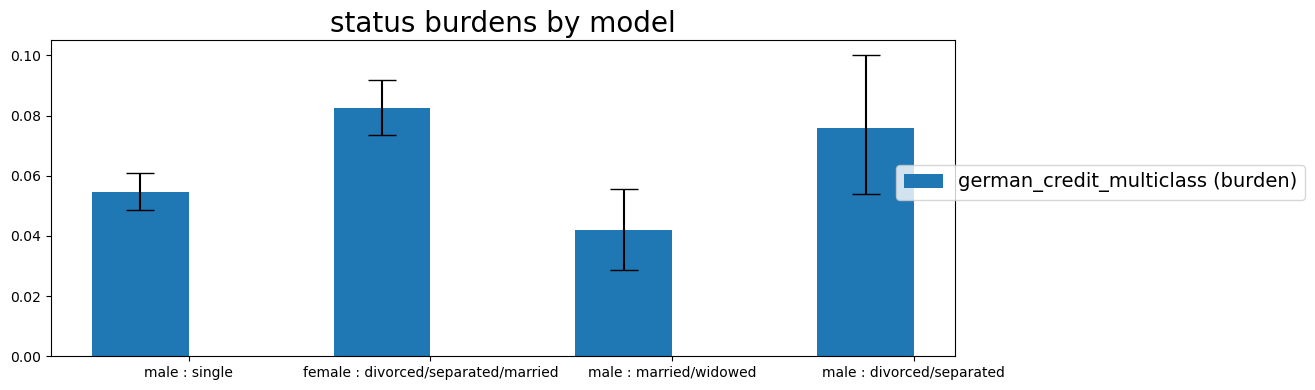

In [19]:
%matplotlib inline
pd.set_option('display.max_column', 100)
display(df_fairness)

# since status is a target encoded variable;
# for plotting values in non-encoded space we make use of the `target_mappings` dict

groups  = list(target_mappings['status'].keys())

feature_scores = df_fairness[[f"Group details ({g})" for g in groups]]
feature_lower_bounds = df_fairness[[f + ' lower bound' for f in feature_scores]]
feature_upper_bounds = df_fairness[[f + ' upper bound' for f in feature_scores]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('status burdens by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(groups))+width)
ax.set_xticklabels(groups)

for idx in range(len(df_fairness)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(groups))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df_fairness.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

### (fairness) age burdens by model

,context,type,fairness,Feature (age),Feature (age) lower bound,Feature (age) upper bound,type in Feature (age),Group details (<= 25 years),Group details (<= 25 years) lower bound,Group details (<= 25 years) upper bound,type in Feature (age),Group details (> 25 years),Group details (> 25 years) lower bound,Group details (> 25 years) upper bound,Feature (status),Feature (status) lower bound,Feature (status) upper bound,type in Feature (status),Group details (female : divorced/separated/married),Group details (female : divorced/separated/married) lower bound,Group details (female : divorced/separated/married) upper bound,type in Feature (status),Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,type in Feature (status),Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,type in Feature (status),Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
german_credit_multiclass (burden),german_credit_multiclass,burden,73.098042,73.098042,66.423246,80.803324,burden,0.096419,0.084086,0.108157,burden,0.055454,0.050338,0.060871,80.319882,72.480605,87.273055,burden,0.082582,0.073564,0.091792,burden,0.076,0.053846,0.1,burden,0.041863,0.028709,0.055683,burden,0.054698,0.048562,0.061


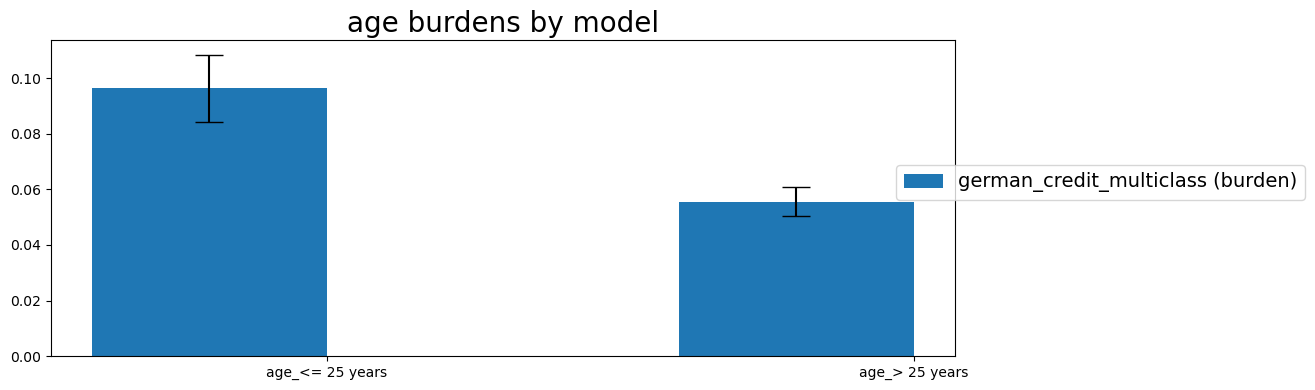

In [20]:
%matplotlib inline
display(df_fairness)
# since age is a one-hot encoded variable;
# for plotting values in non-encoded space we make use of the `one_hot_value_mappings` dict

groups_disp, groups  = list(one_hot_value_mappings['age'].keys()), list(one_hot_value_mappings['age'].values())

feature_scores = df_fairness[[f"Group details ({g})" for g in groups]]
feature_lower_bounds = df_fairness[[f + ' lower bound' for f in feature_scores]]
feature_upper_bounds = df_fairness[[f + ' upper bound' for f in feature_scores]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('age burdens by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(groups))+width)
ax.set_xticklabels(groups_disp)

for idx in range(len(df_fairness)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(groups))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df_fairness.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

### Feature Fairness by model 

,context,type,fairness,Feature (age),Feature (age) lower bound,Feature (age) upper bound,type in Feature (age),Group details (<= 25 years),Group details (<= 25 years) lower bound,Group details (<= 25 years) upper bound,type in Feature (age),Group details (> 25 years),Group details (> 25 years) lower bound,Group details (> 25 years) upper bound,Feature (status),Feature (status) lower bound,Feature (status) upper bound,type in Feature (status),Group details (female : divorced/separated/married),Group details (female : divorced/separated/married) lower bound,Group details (female : divorced/separated/married) upper bound,type in Feature (status),Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,type in Feature (status),Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,type in Feature (status),Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
german_credit_multiclass (burden),german_credit_multiclass,burden,73.098042,73.098042,66.423246,80.803324,burden,0.096419,0.084086,0.108157,burden,0.055454,0.050338,0.060871,80.319882,72.480605,87.273055,burden,0.082582,0.073564,0.091792,burden,0.076,0.053846,0.1,burden,0.041863,0.028709,0.055683,burden,0.054698,0.048562,0.061


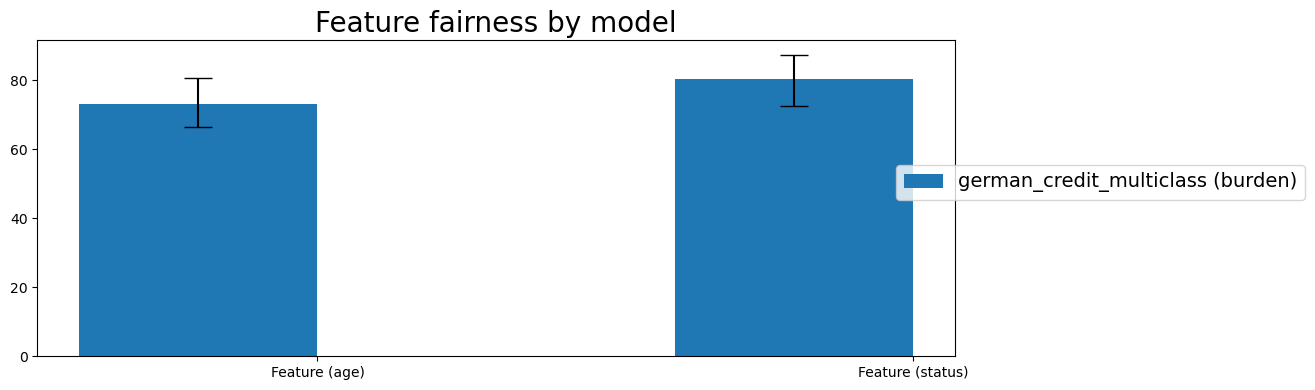

In [21]:
display(df_fairness)

print("\n")

# Let's chart the fairness measure by feature for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (age)', 'Feature (status)']
feature_scores = df_fairness[features]
feature_lower_bounds = df_fairness[[f + ' lower bound' for f in features]]
feature_upper_bounds = df_fairness[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df_fairness)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df_fairness.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

### Robustness by model

- The following cell shows how to extract Certifai Robustness Score from the scan results object
- The high Robustness score indicates the given model needs to change larger no. of features to alter the prediction outcomes
- please refer to official documentation for [Certifai Robustness](https://cognitivescale.github.io/cortex-certifai/docs/information/factors/robustness)

,context,robustness,robustness lower bound,robustness upper bound
german_credit_multiclass,german_credit_multiclass,82.430915,78.420941,86.227454


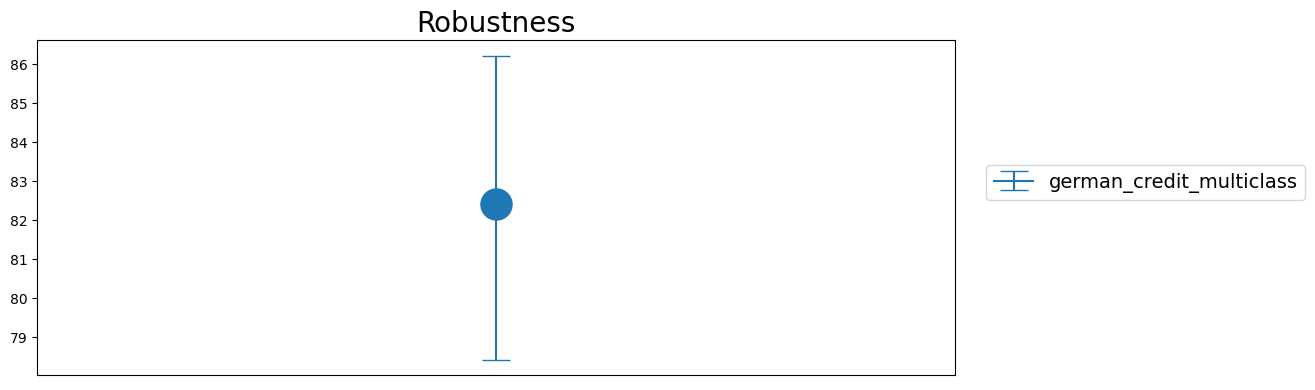

In [22]:
df_robustness = construct_scores_dataframe(scores('robustness', result), include_confidence=True)
display(df_robustness)

%matplotlib inline
import matplotlib.pyplot as plt

features = ['robustness']
feature_scores = df_robustness[features]
feature_lower_bounds = df_robustness[[f + ' lower bound' for f in features]]
feature_upper_bounds = df_robustness[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Robustness', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df_robustness)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.errorbar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df_robustness.index[idx],
            capsize=10)
    
    ax.scatter([width/2+idx*width+f_idx for f_idx in range(len(features))], central_values,s=500)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

### Explainability by model 

- the following cell shows how to extract Certifai Explainability Score from the scan results object
- please refer to official documentation for [Certifai Explainability](https://cognitivescale.github.io/cortex-certifai/docs/information/factors/explainability)

,context,explainability,Num features (1),Num features (10),Num features (2),Num features (3),Num features (4),Num features (5),Num features (6),Num features (7),Num features (8),Num features (9)
german_credit_multiclass,german_credit_multiclass,96.445312,70.3125,0.0,25.78125,3.90625,0.0,0.0,0.0,0.0,0.0,0.0


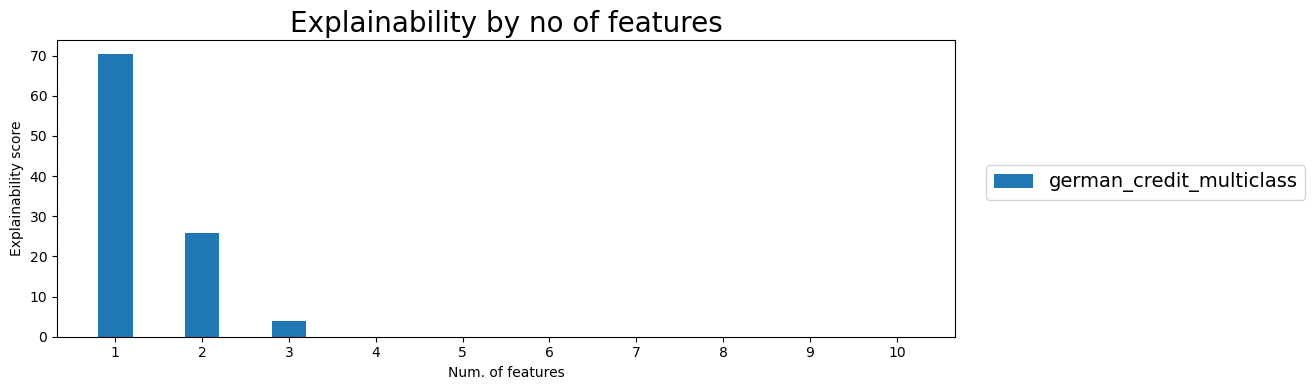

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

df_explainability= construct_scores_dataframe(scores('explainability', result), include_confidence=True)
display(df_explainability)


features = ['Num features (1)', 'Num features (2)', 'Num features (3)', 'Num features (4)', 'Num features (5)', 'Num features (6)', 'Num features (7)', 'Num features (8)', 'Num features (9)', 'Num features (10)']
features_disp = [i for i in range(1,11)]
feature_scores = df_explainability[features]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Explainability by no of features', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features_disp)
ax.set_xlabel("Num. of features")
ax.set_ylabel("Explainability score")

for idx in range(len(df_explainability)):
    central_values = list(feature_scores.iloc[idx])

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,align='edge',
            color=colors[idx],
            label=df_explainability.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()